Begun 5/6/24

The last notebook demonstrated that the recovery of the angle is unbiased for a large number of sims at random angles (though very small input angles generate very large percent errors because they have a signal-to-noise that is very small or even less than 1). That was all for the noise extrapolated from a single depth-1 map, though. This notebook will test whether the noise properties of different depth-1 maps are similar enough that our conclusion about the method working holds for most or all of the maps we will encounter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [3]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [4]:
from scipy.optimize import curve_fit
def power_law(x,a,b):
    return a*np.power(x,b)

In [19]:
# Testing noise spectra for five random depth-1 maps

# Loading in depth-1 map, calculating power spectra without filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90 # Do we want to turn off filtering here? Not now - want it to be realistic to what we will have
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/'
# These cuts are so that I am fitting only the power law tail, not whatever happens near the filtering
# The original values of 35 and 5 didn't fit all five maps super well, though not terribly either
t_index_cut = 45
p_index_cut = 10

# First map
depth1_T_1, depth1_E_1, depth1_B_1, w2_1 = load_and_filter_depth1_with_T(depth1_path + lines[0])
ell_b, depth1_TT_1, bincount = spectrum_from_maps(depth1_T_1,depth1_T_1,1.0,w2_1,lmax,bin_size)
_, depth1_EE_1, _ = spectrum_from_maps(depth1_E_1,depth1_E_1,1.0,w2_1,lmax,bin_size)
_, depth1_BB_1, _ = spectrum_from_maps(depth1_B_1,depth1_B_1,1.0,w2_1,lmax,bin_size)
TT_fit_1, _ = curve_fit(f=power_law, xdata=ell_b[t_index_cut:], ydata=depth1_TT_1[t_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit_1, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_EE_1[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit_1, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_BB_1[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))

# Second map - should be the same area as map 1 but a different array
depth1_T_2, depth1_E_2, depth1_B_2, w2_2 = load_and_filter_depth1_with_T(depth1_path + lines[1])
ell_b, depth1_TT_2, bincount = spectrum_from_maps(depth1_T_2,depth1_T_2,1.0,w2_2,lmax,bin_size)
_, depth1_EE_2, _ = spectrum_from_maps(depth1_E_2,depth1_E_2,1.0,w2_2,lmax,bin_size)
_, depth1_BB_2, _ = spectrum_from_maps(depth1_B_2,depth1_B_2,1.0,w2_2,lmax,bin_size)
TT_fit_2, _ = curve_fit(f=power_law, xdata=ell_b[t_index_cut:], ydata=depth1_TT_2[t_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit_2, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_EE_2[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit_2, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_BB_2[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))

# Third map
depth1_T_3, depth1_E_3, depth1_B_3, w2_3 = load_and_filter_depth1_with_T(depth1_path + lines[15])
ell_b, depth1_TT_3, bincount = spectrum_from_maps(depth1_T_3,depth1_T_3,1.0,w2_3,lmax,bin_size)
_, depth1_EE_3, _ = spectrum_from_maps(depth1_E_3,depth1_E_3,1.0,w2_3,lmax,bin_size)
_, depth1_BB_3, _ = spectrum_from_maps(depth1_B_3,depth1_B_3,1.0,w2_3,lmax,bin_size)
TT_fit_3, _ = curve_fit(f=power_law, xdata=ell_b[t_index_cut:], ydata=depth1_TT_3[t_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit_3, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_EE_3[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit_3, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_BB_3[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))

# Fourth map
depth1_T_4, depth1_E_4, depth1_B_4, w2_4 = load_and_filter_depth1_with_T(depth1_path + lines[30])
ell_b, depth1_TT_4, bincount = spectrum_from_maps(depth1_T_4,depth1_T_4,1.0,w2_4,lmax,bin_size)
_, depth1_EE_4, _ = spectrum_from_maps(depth1_E_4,depth1_E_4,1.0,w2_4,lmax,bin_size)
_, depth1_BB_4, _ = spectrum_from_maps(depth1_B_4,depth1_B_4,1.0,w2_4,lmax,bin_size)
TT_fit_4, _ = curve_fit(f=power_law, xdata=ell_b[t_index_cut:], ydata=depth1_TT_4[t_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit_4, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_EE_4[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit_4, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_BB_4[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))

# Fifth map
depth1_T_5, depth1_E_5, depth1_B_5, w2_5 = load_and_filter_depth1_with_T(depth1_path + lines[45])
ell_b, depth1_TT_5, bincount = spectrum_from_maps(depth1_T_5,depth1_T_5,1.0,w2_5,lmax,bin_size)
_, depth1_EE_5, _ = spectrum_from_maps(depth1_E_5,depth1_E_5,1.0,w2_5,lmax,bin_size)
_, depth1_BB_5, _ = spectrum_from_maps(depth1_B_5,depth1_B_5,1.0,w2_5,lmax,bin_size)
TT_fit_5, _ = curve_fit(f=power_law, xdata=ell_b[t_index_cut:], ydata=depth1_TT_5[t_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
EE_fit_5, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_EE_5[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))
BB_fit_5, _ = curve_fit(f=power_law, xdata=ell_b[p_index_cut:], ydata=depth1_BB_5[p_index_cut:], p0=[0,0],bounds=(-np.inf,np.inf))

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits
/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa5_f150_map.fits
/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494587192_pa5_f150_map.fits
/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1513422389_pa6_f150_map.fits
/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1513479282_pa6_f150_map.fits


[ 7.80804704e+14 -4.65189509e+00]
[ 2.39825640e+04 -1.57397727e+00]
[ 1.76637024e+04 -1.50349103e+00]


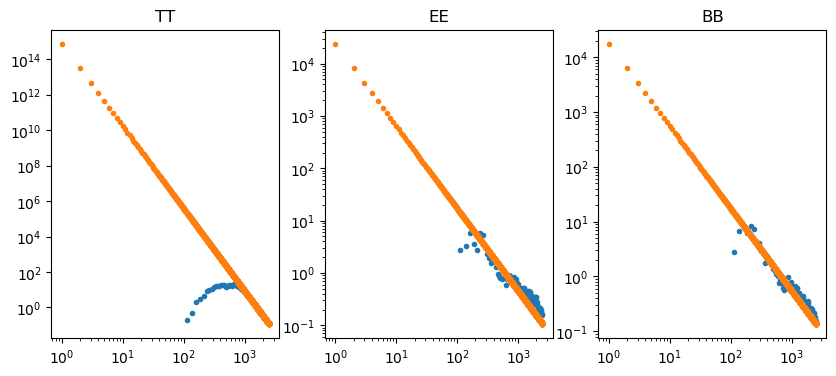

[ 6.61248377e+15 -4.99668742e+00]
[ 4.66368207e+04 -1.63410156e+00]
[ 1.79721798e+04 -1.50829531e+00]


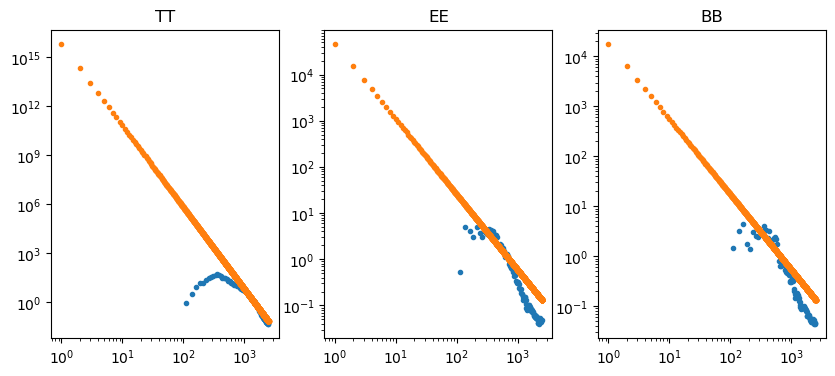

[ 5.88875237e+17 -5.41150196e+00]
[ 1.86151182e+04 -1.34260040e+00]
[ 2.08154693e+03 -1.05740059e+00]


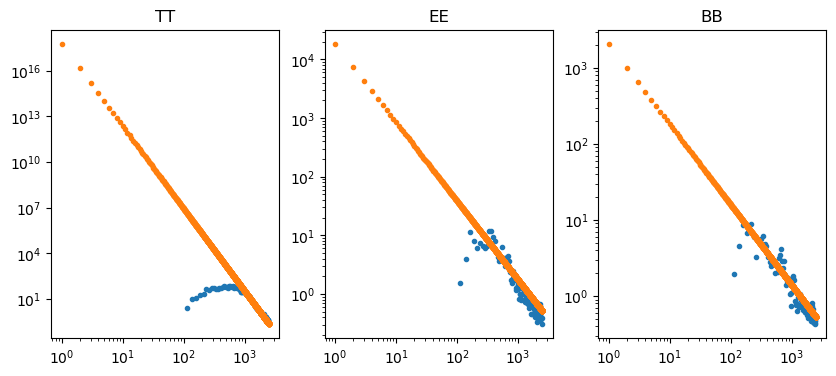

[ 1.19063810e+12 -3.84786952e+00]
[ 1.46816720e+05 -2.02779449e+00]
[ 1.89782075e+07 -2.70514965e+00]


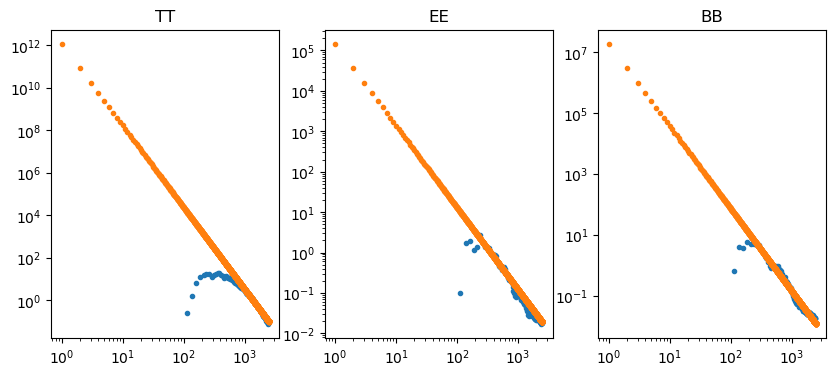

[ 3.06325392e+10 -3.11997948e+00]
[ 3.47870284e+04 -1.81254243e+00]
[ 5.41360349e+06 -2.54242161e+00]


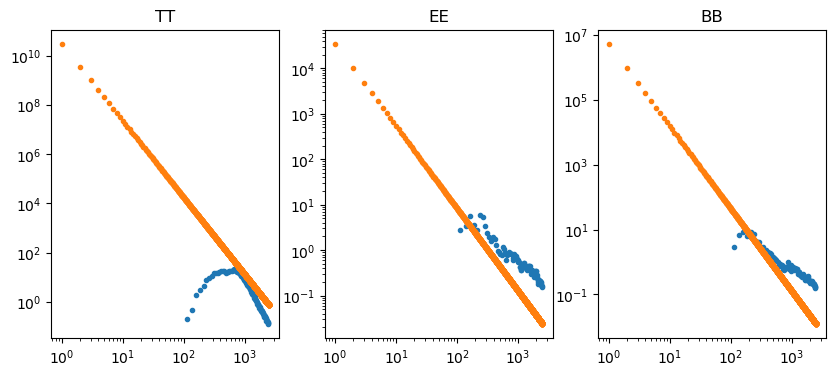

In [20]:
# Checking fits
fig1, axs = plt.subplots(1,3, figsize=(10,4))
print(TT_fit_1)
axs[0].loglog(ell_b, depth1_TT_1, marker=".", ls="none",label = "TT")
axs[0].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit_1), marker=".", ls="none",label = "fit")
axs[0].set_title('TT')
print(EE_fit_1)
axs[1].loglog(ell_b, depth1_EE_1, marker=".", ls="none",label = "EE")
axs[1].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit_1), marker=".", ls="none",label = "fit")
axs[1].set_title('EE')
print(BB_fit_1)
axs[2].loglog(ell_b, depth1_BB_1, marker=".", ls="none",label = "BB")
axs[2].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit_1), marker=".", ls="none",label = "fit")
axs[2].set_title('BB')
plt.show()
plt.close()
fig2, axs = plt.subplots(1,3, figsize=(10,4))
print(TT_fit_2)
axs[0].loglog(ell_b, depth1_TT_2, marker=".", ls="none",label = "TT")
axs[0].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit_2), marker=".", ls="none",label = "fit")
axs[0].set_title('TT')
print(EE_fit_2)
axs[1].loglog(ell_b, depth1_EE_2, marker=".", ls="none",label = "EE")
axs[1].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit_2), marker=".", ls="none",label = "fit")
axs[1].set_title('EE')
print(BB_fit_2)
axs[2].loglog(ell_b, depth1_BB_2, marker=".", ls="none",label = "BB")
axs[2].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit_2), marker=".", ls="none",label = "fit")
axs[2].set_title('BB')
plt.show()
plt.close()
fig3, axs = plt.subplots(1,3, figsize=(10,4))
print(TT_fit_3)
axs[0].loglog(ell_b, depth1_TT_3, marker=".", ls="none",label = "TT")
axs[0].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit_3), marker=".", ls="none",label = "fit")
axs[0].set_title('TT')
print(EE_fit_3)
axs[1].loglog(ell_b, depth1_EE_3, marker=".", ls="none",label = "EE")
axs[1].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit_3), marker=".", ls="none",label = "fit")
axs[1].set_title('EE')
print(BB_fit_3)
axs[2].loglog(ell_b, depth1_BB_3, marker=".", ls="none",label = "BB")
axs[2].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit_3), marker=".", ls="none",label = "fit")
axs[2].set_title('BB')
plt.show()
plt.close()
fig4, axs = plt.subplots(1,3, figsize=(10,4))
print(TT_fit_4)
axs[0].loglog(ell_b, depth1_TT_4, marker=".", ls="none",label = "TT")
axs[0].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit_4), marker=".", ls="none",label = "fit")
axs[0].set_title('TT')
print(EE_fit_4)
axs[1].loglog(ell_b, depth1_EE_4, marker=".", ls="none",label = "EE")
axs[1].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit_4), marker=".", ls="none",label = "fit")
axs[1].set_title('EE')
print(BB_fit_4)
axs[2].loglog(ell_b, depth1_BB_4, marker=".", ls="none",label = "BB")
axs[2].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit_4), marker=".", ls="none",label = "fit")
axs[2].set_title('BB')
plt.show()
plt.close()
fig5, axs = plt.subplots(1,3, figsize=(10,4))
print(TT_fit_5)
axs[0].loglog(ell_b, depth1_TT_1, marker=".", ls="none",label = "TT")
axs[0].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *TT_fit_5), marker=".", ls="none",label = "fit")
axs[0].set_title('TT')
print(EE_fit_5)
axs[1].loglog(ell_b, depth1_EE_1, marker=".", ls="none",label = "EE")
axs[1].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *EE_fit_5), marker=".", ls="none",label = "fit")
axs[1].set_title('EE')
print(BB_fit_5)
axs[2].loglog(ell_b, depth1_BB_1, marker=".", ls="none",label = "BB")
axs[2].loglog(np.arange(1,2501), power_law(np.arange(1,2501), *BB_fit_5), marker=".", ls="none",label = "fit")
axs[2].set_title('BB')
plt.show()
plt.close()

In [21]:
# Fitting two of them to noise spectra for running full sims
noise_TT_3 = np.zeros(arr_len)
noise_EE_3 = np.zeros(arr_len)
noise_BB_3 = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
noise_TT_3[90:2501] = power_law(np.arange(90,2501), *TT_fit_3)
noise_EE_3[90:2501] = power_law(np.arange(90,2501), *EE_fit_3)
noise_BB_3[90:2501] = power_law(np.arange(90,2501), *BB_fit_3)
noise_TT_4 = np.zeros(arr_len)
noise_EE_4 = np.zeros(arr_len)
noise_BB_4 = np.zeros(arr_len)
# Starting at ell=90 to miss regions that should be filtered out
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
noise_TT_4[90:2501] = power_law(np.arange(90,2501), *TT_fit_4)
noise_EE_4[90:2501] = power_law(np.arange(90,2501), *EE_fit_4)
noise_BB_4[90:2501] = power_law(np.arange(90,2501), *BB_fit_4)

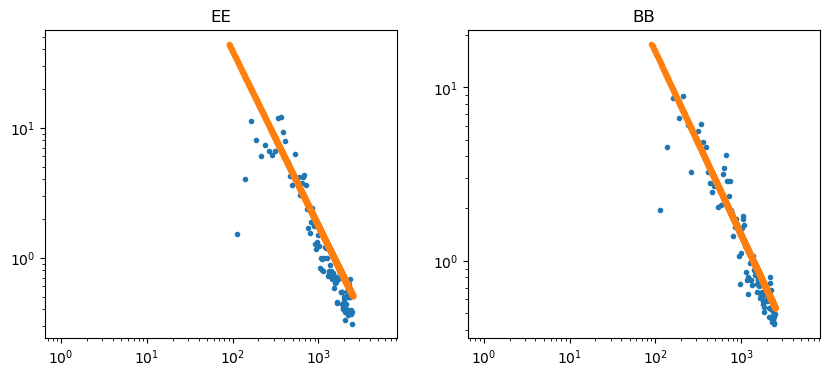

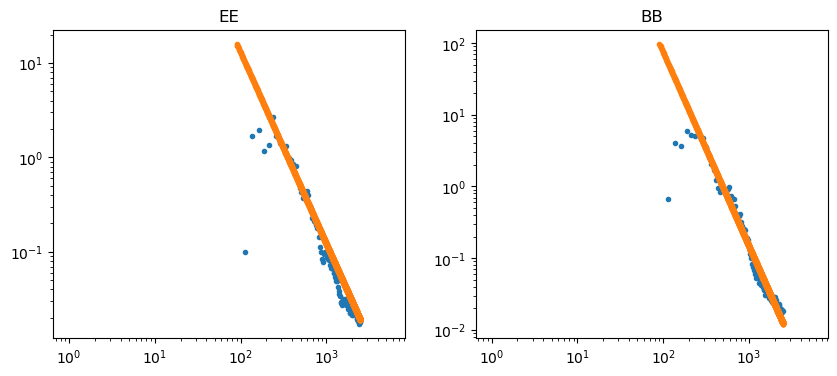

In [24]:
# Comparing noise spectra to real spectra in range ell>90
fig3, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].loglog(ell_b, depth1_EE_3, marker=".", ls="none",label = "EE")
axs[0].loglog(np.arange(arr_len), noise_EE_3, marker=".", ls="none",label = "fit")
axs[0].set_title('EE')
axs[1].loglog(ell_b, depth1_BB_3, marker=".", ls="none",label = "BB")
axs[1].loglog(np.arange(arr_len), noise_BB_3, marker=".", ls="none",label = "fit")
axs[1].set_title('BB')
plt.show()
plt.close()
fig4, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].loglog(ell_b, depth1_EE_4, marker=".", ls="none",label = "EE")
axs[0].loglog(np.arange(arr_len), noise_EE_4, marker=".", ls="none",label = "fit")
axs[0].set_title('EE')
axs[1].loglog(ell_b, depth1_BB_4, marker=".", ls="none",label = "BB")
axs[1].loglog(np.arange(arr_len), noise_BB_4, marker=".", ls="none",label = "fit")
axs[1].set_title('BB')
plt.show()
plt.close()

In [27]:
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def sample_likelihood_and_max(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = estimator_likelihood(angle,estimator,covariance,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # I don't expect there to be issues with multiple max values
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def sample_null_eb_likelihood_and_max(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the max of the likelihood
       without any fitting for a Gaussian
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)

    bin_sampled_likelihood = []
    
    for angle in angles_rad:
        likelihood = null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE)
        bin_sampled_likelihood.append(likelihood)

    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    max_index = np.where(norm_sampled_likelihood == np.max(norm_sampled_likelihood))[0][0]
    like_max_deg = np.rad2deg(angles_rad[max_index])
    
    return like_max_deg

def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [28]:
# Doing 500 sims of full sky maps plus noise for the rotated map ONLY 
# with an ell range of 200-1000
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Using random angles and the noise from depth-1 map 3
min_ell = 200
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(N_sims))
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    noise_maps = hp.sphtfunc.synfast((noise_TT_3, np.zeros(noise_TT_3.size), noise_EE_3, noise_BB_3),nside)
    # Adding them together for rot maps ONLY
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range back to being centered at zero for the random distribution of angles
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=10000)

    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:26:09<00:00, 17.54s/it]


Median of full sky percent error, map based estimator: -2.639314380648133
Mean of full sky percent error, map based estimator: -26.216425604439273
Std dev of full sky percent error, map based estimator: 676.8529121122165


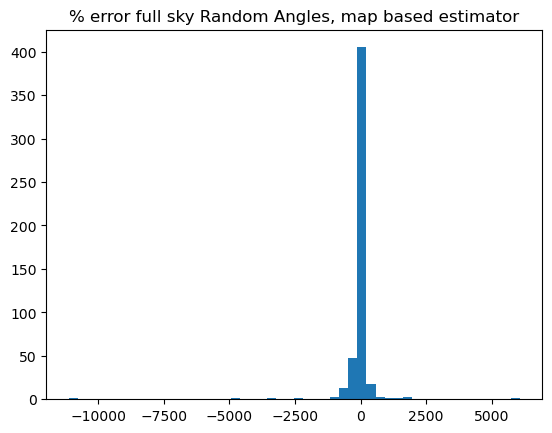

Median of full sky percent error: -1.364207852879909
Mean of full sky percent error: -91.70375849708567
Std dev of full sky percent error: 1348.5745775171852


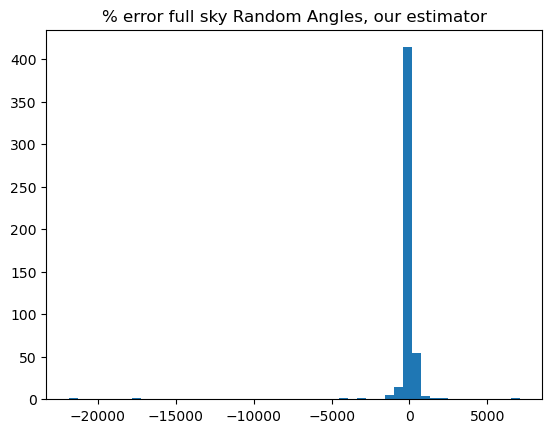

Median of full sky percent error EB estimator: 121.3349277818954
Mean of full sky percent error EB estimator: -46.64167073943923
Std dev of full sky percent error EB estimator: 10096.279376088683


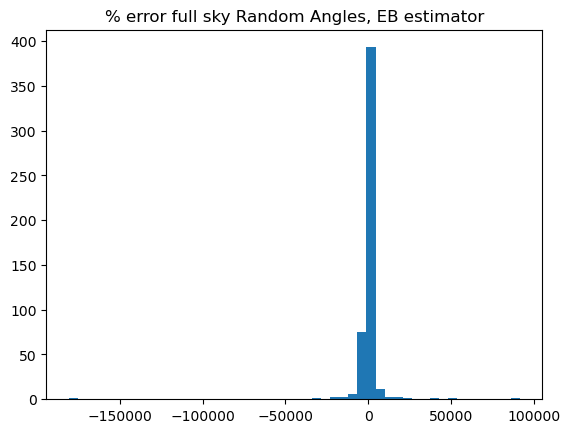

Median of full sky angles Unrot EB estimator: -0.0010001000100015034
Mean of full sky angles Unrot EB estimator: -6.800680068009513e-05
Std dev of full sky angles Unrot EB estimator: 0.0018772535206827807


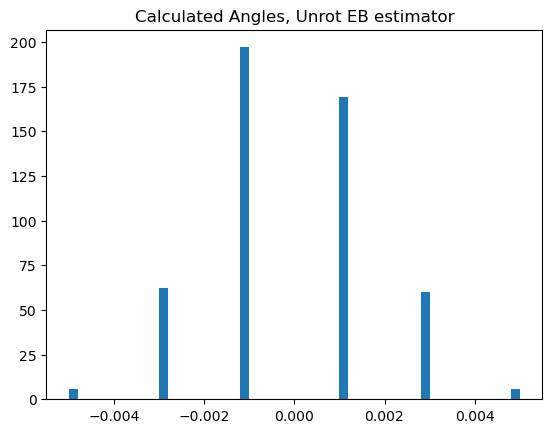

Median of full sky mean TT ratio: 0.999989788146664
Mean of full sky mean TT ratio: 1.0000015434787939
Std dev of full sky mean TT ratio: 0.0015396073185928365


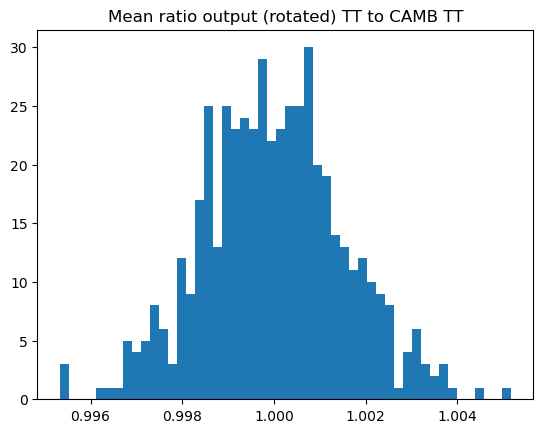

In [29]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky Random Angles, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky Random Angles, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky Random Angles, EB estimator")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

Median of full sky percent error, map based estimator: -1.877120153872579
Mean of full sky percent error, map based estimator: -2.3189312953801156
Std dev of full sky percent error, map based estimator: 41.12131379612693


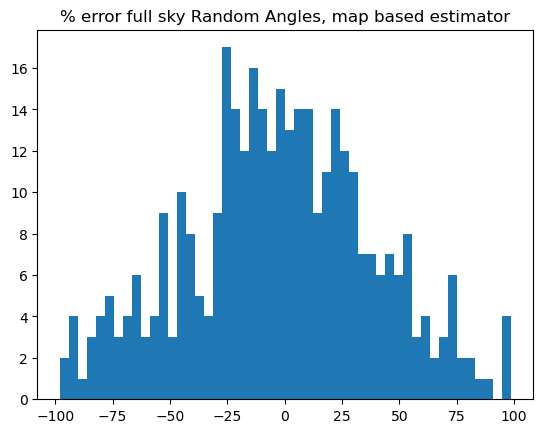

Median of full sky percent error: 0.9973089677297821
Mean of full sky percent error: -0.80716512821417
Std dev of full sky percent error: 44.44982246179228


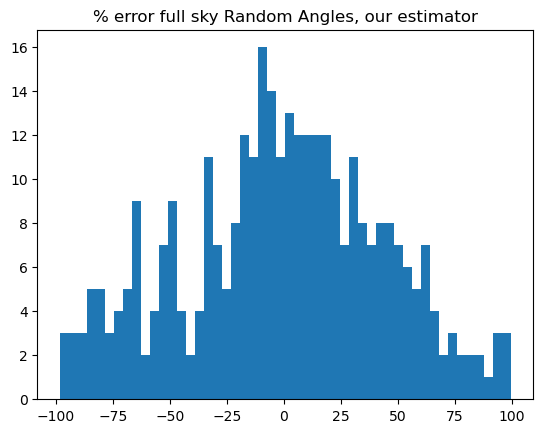

In [30]:
# Cutting out the big outliers
indices_no_outliers_mapbased = np.where(np.abs(mapbased_percent_diff)<100.0)[0]
indices_no_outliers_estimator = np.where(np.abs(percent_diff)<100.0)[0]
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff[indices_no_outliers_mapbased])))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff[indices_no_outliers_mapbased])))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff[indices_no_outliers_mapbased])))
plt.hist(mapbased_percent_diff[indices_no_outliers_mapbased],bins=50)
plt.title("% error full sky Random Angles, map based estimator")
plt.show()
plt.close()
print("Median of full sky percent error: " + str(np.median(percent_diff[indices_no_outliers_estimator])))
print("Mean of full sky percent error: " + str(np.mean(percent_diff[indices_no_outliers_estimator])))
print("Std dev of full sky percent error: " + str(np.std(percent_diff[indices_no_outliers_estimator])))
plt.hist(percent_diff[indices_no_outliers_estimator],bins=50)
plt.title("% error full sky Random Angles, our estimator")
plt.show()
plt.close()

All seems well with this depth-1 map's noise profile as well (the outliers in percent difference are from very small angles that are swamped by noise, just like the first depth-1 map). Moving on to trying another with higher noise.

In [31]:
# Doing 500 sims of full sky maps plus noise for the rotated map ONLY 
# with an ell range of 200-1000
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Doing the rotation in PS space instead of map space

# Using random angles and the noise from depth-1 map 4
min_ell = 200
max_ell = 1000
N_sims = 500
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(N_sims))
noise_seeds = np.random.randint(0,10000,size=rot_degs.size)
for i in tqdm(range(N_sims)):
    rot_deg = rot_degs[i]
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = i # Ensures it is different each time
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at rotated angle to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise with a random seed
    np.random.seed(noise_seeds[i])
    noise_maps = hp.sphtfunc.synfast((noise_TT_4, np.zeros(noise_TT_4.size), noise_EE_4, noise_BB_4),nside)
    # Adding them together for rot maps ONLY
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    # Changing the fit range back to being centered at zero for the random distribution of angles
    # Using larger number of points to ensure good angle resolution
    fit_values = sample_likelihood_and_max(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)

    null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=100000)
    # This should again be zero since there is no noise anymore in the unrotated maps
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_max(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-10.0,angle_max_deg=10.0,num_pts=10000)

    # Changing this back to ClTT_unrot instead of ClTT_rot so that it should again be an assessment
    # of whether the recovery of the CAMB spectra by anafast is unbiased (since there is no noise in unrot maps to
    # make this meaningless anymore)
    tt_bias_outputs.append(np.mean(ClTT_unrot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles) # Only angle returned now
output_null_eb_angles_only = np.array(output_null_eb_angles)
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [2:25:10<00:00, 17.42s/it]


Median of full sky percent error, map based estimator: -1.1308348789623255
Mean of full sky percent error, map based estimator: 23.23494750902611
Std dev of full sky percent error, map based estimator: 607.0956664759465


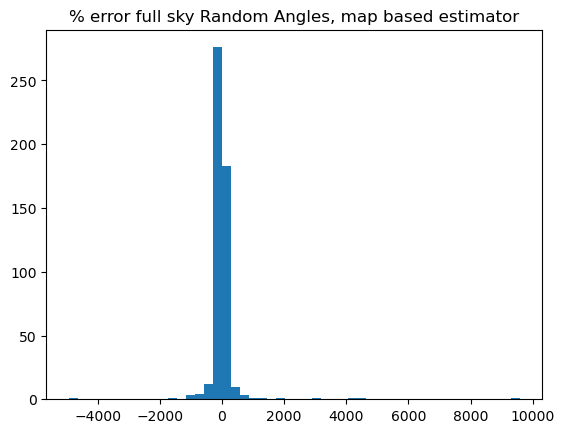

Median of full sky percent error: -1.8471831820828575
Mean of full sky percent error: -65.36845087704889
Std dev of full sky percent error: 991.3197592429241


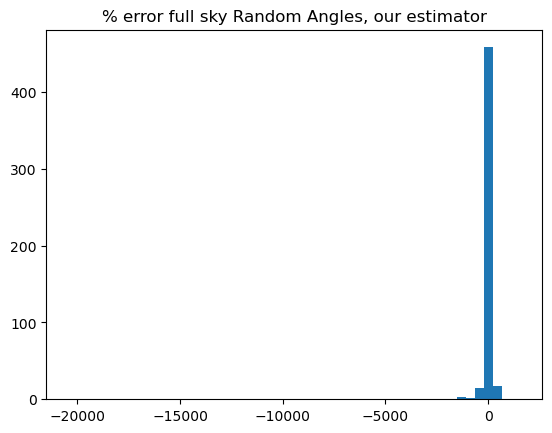

Median of full sky percent error EB estimator: -78.7447469636052
Mean of full sky percent error EB estimator: -1150.108504874517
Std dev of full sky percent error EB estimator: 22164.00959091098


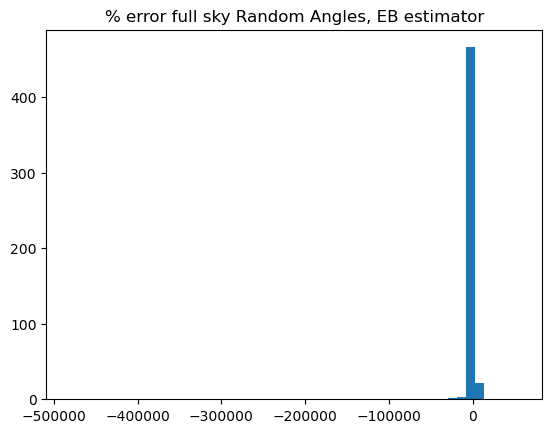

Median of full sky angles Unrot EB estimator: -0.0010001000100015034
Mean of full sky angles Unrot EB estimator: -6.800680068009513e-05
Std dev of full sky angles Unrot EB estimator: 0.0018772535206827807


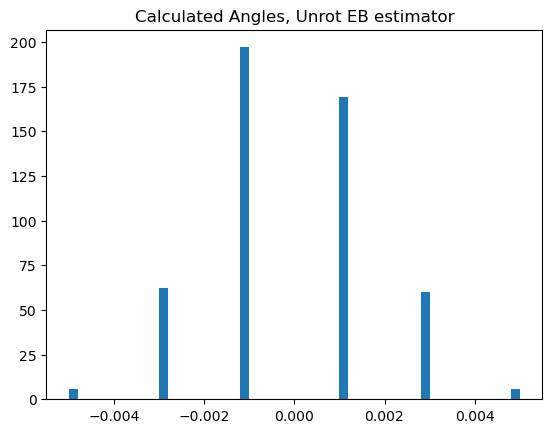

Median of full sky mean TT ratio: 0.999989788146664
Mean of full sky mean TT ratio: 1.0000015434787939
Std dev of full sky mean TT ratio: 0.0015396073185928365


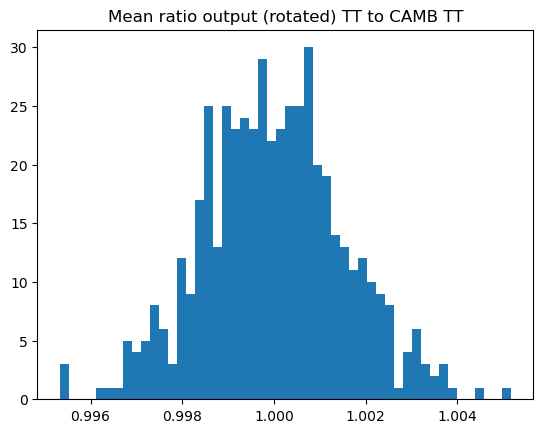

In [32]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky Random Angles, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky Random Angles, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky Random Angles, EB estimator")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

Median of full sky percent error, map based estimator: 0.055666731989457284
Mean of full sky percent error, map based estimator: -1.0955804834800773
Std dev of full sky percent error, map based estimator: 38.137085918419736


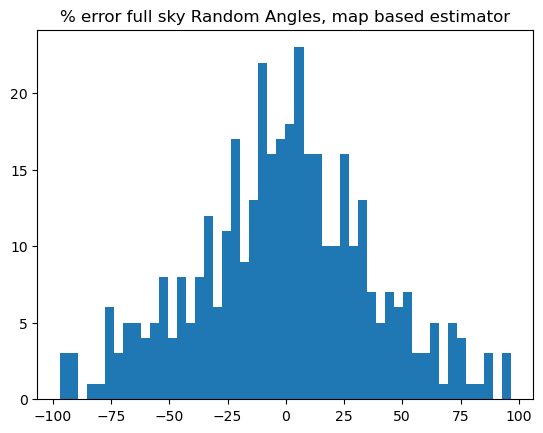

Median of full sky percent error: -1.5891391835022004
Mean of full sky percent error: -0.6104139843758736
Std dev of full sky percent error: 34.78558242299108


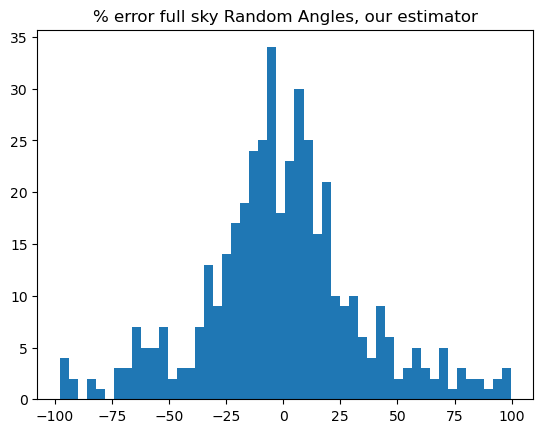

In [33]:
# Cutting out the big outliers
indices_no_outliers_mapbased = np.where(np.abs(mapbased_percent_diff)<100.0)[0]
indices_no_outliers_estimator = np.where(np.abs(percent_diff)<100.0)[0]
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff[indices_no_outliers_mapbased])))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff[indices_no_outliers_mapbased])))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff[indices_no_outliers_mapbased])))
plt.hist(mapbased_percent_diff[indices_no_outliers_mapbased],bins=50)
plt.title("% error full sky Random Angles, map based estimator")
plt.show()
plt.close()
print("Median of full sky percent error: " + str(np.median(percent_diff[indices_no_outliers_estimator])))
print("Mean of full sky percent error: " + str(np.mean(percent_diff[indices_no_outliers_estimator])))
print("Std dev of full sky percent error: " + str(np.std(percent_diff[indices_no_outliers_estimator])))
plt.hist(percent_diff[indices_no_outliers_estimator],bins=50)
plt.title("% error full sky Random Angles, our estimator")
plt.show()
plt.close()

Median of full sky angles, our estimator: 0.4118041180411822
Mean of full sky angles, our estimator: 0.17625376253762637
Std dev of full sky angles, our estimator: 5.023284328683934


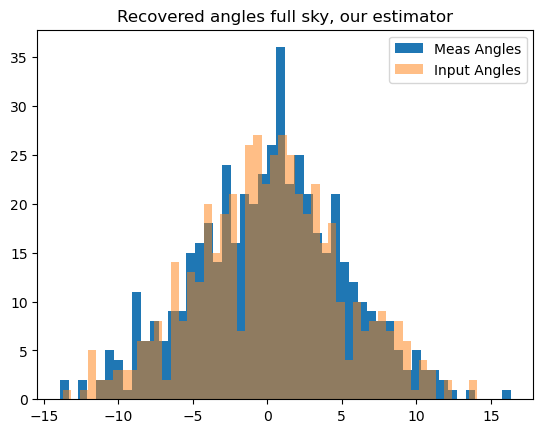

Median of full sky angles, map based estimator: 0.3341854419061489
Mean of full sky angles, map based estimator: 0.10541163106761413
Std dev of full sky angles, map based estimator: 5.130573327858141


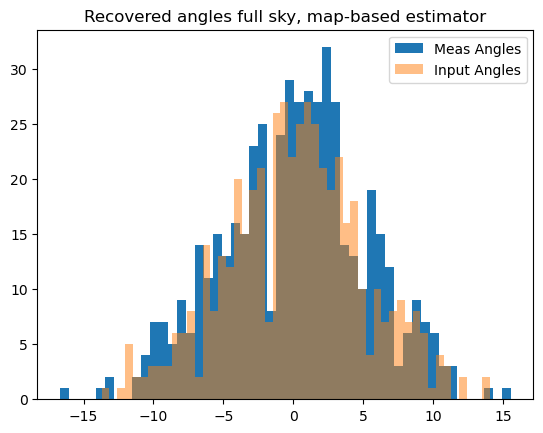

In [37]:
# Plotting the input angles vs the recoverd angles
print("Median of full sky angles, our estimator: " + str(np.median(output_angles_only)))
print("Mean of full sky angles, our estimator: " + str(np.mean(output_angles_only)))
print("Std dev of full sky angles, our estimator: " + str(np.std(output_angles_only)))
plt.hist(output_angles_only,bins=50,label='Meas Angles')
plt.hist(rot_degs,bins=50,label="Input Angles",alpha=0.5)
plt.title("Recovered angles full sky, our estimator")
plt.legend()
plt.show()
plt.close()

print("Median of full sky angles, map based estimator: " + str(np.median(output_mapspace_angles)))
print("Mean of full sky angles, map based estimator: " + str(np.mean(output_mapspace_angles)))
print("Std dev of full sky angles, map based estimator: " + str(np.std(output_mapspace_angles)))
plt.hist(output_mapspace_angles,bins=50,label='Meas Angles')
plt.hist(rot_degs,bins=50,label="Input Angles",alpha=0.5)
plt.title("Recovered angles full sky, map-based estimator")
plt.legend()
plt.show()
plt.close()